In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
import os

pp = papiro_path = "./drive/MyDrive/ColabNotebooks/ClassImg" # no meu caso

# Work arround pra montar pastas "Shared with me"
# go to Google Drive, right click on the folder in question, and then click "Add shortcut to Drive".

os.listdir(pp)

['S2',
 'S2_cutted',
 'Prints',
 'S2_AOI_nuvens',
 'Classification_CNN_S2.ipynb',
 'S2_area6_cutted',
 'S2_area8_cutted',
 'S2_area9_cutted',
 'Classification_MLP_S2.ipynb',
 'Classification_MLP_CBERS4A.ipynb',
 'CBERS4A',
 'k_means.gtif',
 'Classification_MLP_S2_P2.ipynb',
 'Clustering_KMeans-S2.ipynb']

In [3]:
import numpy as np
from sklearn import cluster
import matplotlib.pyplot as plt
import pandas as pd
from osgeo import gdal, gdal_array
from scipy.signal import convolve2d
from scipy.ndimage import binary_erosion

## Análise 1 banda

In [4]:



# Tell GDAL to throw Python exceptions, and register all drivers
gdal.UseExceptions()
gdal.AllRegister()

# Read in raster image
img_filename = 'S2B_tile_20190401_20NQH_0_B04.tif'  # SRC: 32620 , UTM/20N (m)
img_path = os.path.join(pp,'S2_cutted',img_filename)
img_ds = gdal.Open(img_path, gdal.GA_ReadOnly)

img = img_ds.ReadAsArray()
print (img.shape)

X = img.reshape((-1,1))
print (X.shape)

# Same for nuvens raster:
# Read in raster image
nuvens_ds = gdal.Open(os.path.join(pp,'S2_AOI_nuvens','nuvens.tif'), gdal.GA_ReadOnly)

nuvens = nuvens_ds.ReadAsArray()
print (nuvens.shape)

Y = nuvens.reshape((-1,1))
print (Y.shape)

(1385, 1393)
(1929305, 1)
(1385, 1393)
(1929305, 1)


## Nuvens são plotadas nos 50% maiores valores:

<Axes: ylabel='Frequency'>

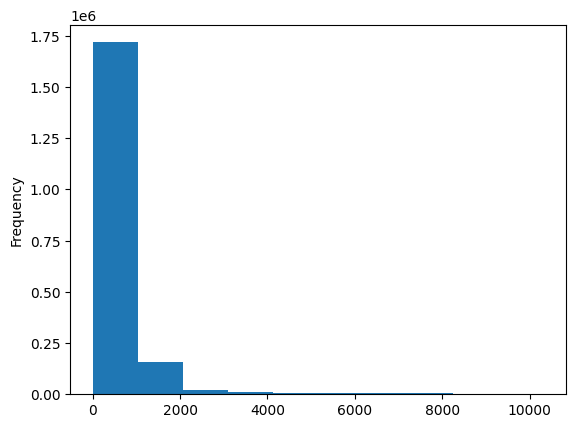

In [5]:
pd.Series(X.reshape((-1,))).plot.hist()

In [6]:
# Process commom model to filter clouds in original raster  img:
out = os.path.join(pp,"S2_AOI_nuvens","nuvens_calc.tif")
r = max(X) * 0.8
comando = 'gdal_calc'
comando += '.bat' if os.name=='nt' else '.py'
comando += f" -A {img_path} "
comando += f'--calc="A>{r}" --co NBITS=1 --type Byte '
comando += f" --outfile {out} --overwrite --quiet --NoDataValue 0"
print(comando)
os.system(comando)

gdal_calc.py -A ./drive/MyDrive/ColabNotebooks/ClassImg/S2_cutted/S2B_tile_20190401_20NQH_0_B04.tif --calc="A>[2062.4]" --co NBITS=1 --type Byte  --outfile ./drive/MyDrive/ColabNotebooks/ClassImg/S2_AOI_nuvens/nuvens_calc.tif --overwrite --quiet --NoDataValue 0


0

In [7]:

calc = gdal.Open(out, gdal.GA_ReadOnly).ReadAsArray()
print (calc.shape)

Y_calc = calc.reshape((-1,1))
print (Y_calc.shape)


(1385, 1393)
(1929305, 1)


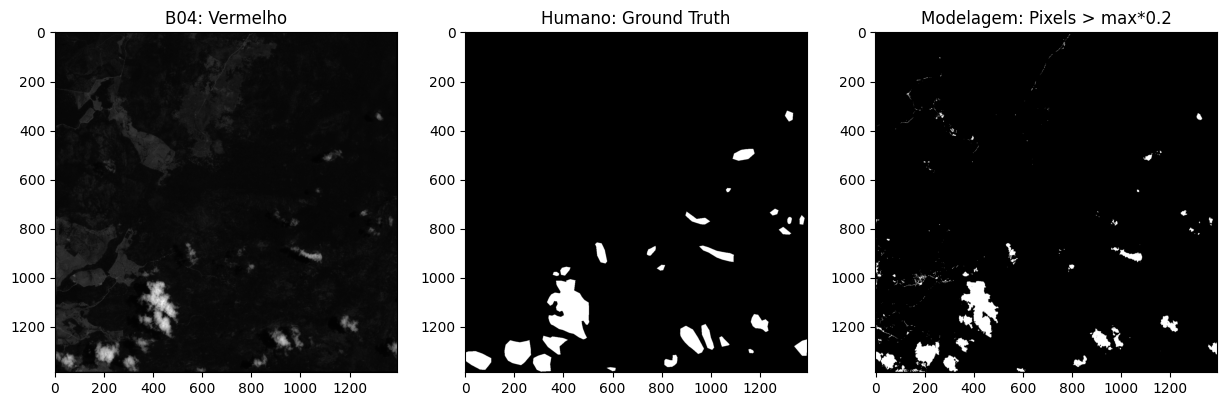

In [8]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15,15))
ax1.set_title("B04: Vermelho")
ax1.imshow(img, cmap=plt.get_cmap("gray"))
ax2.set_title("Humano: Ground Truth")
ax2.imshow(nuvens, cmap=plt.get_cmap("gray"))
ax3.set_title("Modelagem: Pixels > max*0.2")
ax3.imshow(calc, cmap=plt.get_cmap("gray"))
plt.show()

In [9]:
# https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
"""
silhouette = -999
n = 0
for n_clusters in [2,4,6]:
    kmeans = cluster.KMeans(n_clusters=n_clusters, random_state=0, n_init=10) # https://scikit-learn.org/stable/modules/generated/sklearn.cluster.k_means.html#sklearn.cluster.k_means
    cluster_labels = kmeans.fit_predict(X)

    silhouette_avg = silhouette_score(X, cluster_labels)
    if silhouette_avg > silhouette:
        n = n_clusters
        silhouette = silhouette_avg
        labels = cluster_labels
        centroids = kmeans.cluster_centers_
        print(n,silhouette)


print("Best n_clusters:",n)
X_cluster = labels
"""
kmeans3 = cluster.KMeans(n_clusters=3, random_state=0, n_init=10) # https://scikit-learn.org/stable/modules/generated/sklearn.cluster.k_means.html#sklearn.cluster.k_means
X_cluster3 = kmeans3.fit_predict(X)
"""current_labels = [0, 1, 2]
desired_labels = [1, 2, 3]
map_dict = dict(zip(current_labels, desired_labels))
X_cluster3 = np.array([map_dict[i] for i in X_cluster3])"""
X_cluster3 = X_cluster3.reshape(img.shape)

kmeans4 = cluster.KMeans(n_clusters=4, random_state=0, n_init=10)
X_cluster4 = kmeans4.fit_predict(X)
X_cluster4 = X_cluster4.reshape(img.shape)


{0: 1717963, 1: 27296, 2: 184046}


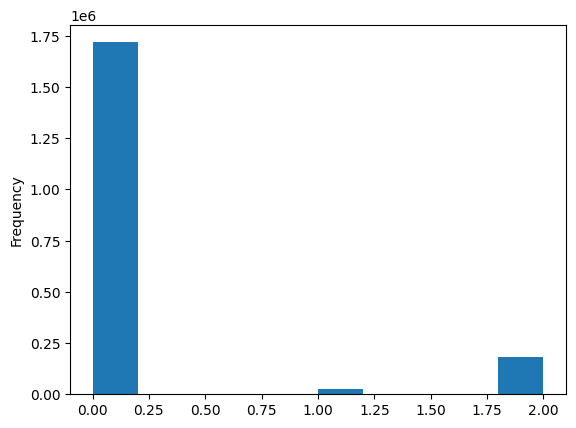

In [10]:
unique, counts = np.unique(X_cluster3.reshape((-1,)), return_counts=True)
print(dict(zip(unique, counts)))

df= pd.Series(X_cluster3.reshape((-1,)))
ax = df.plot.hist()

Plot the classified image

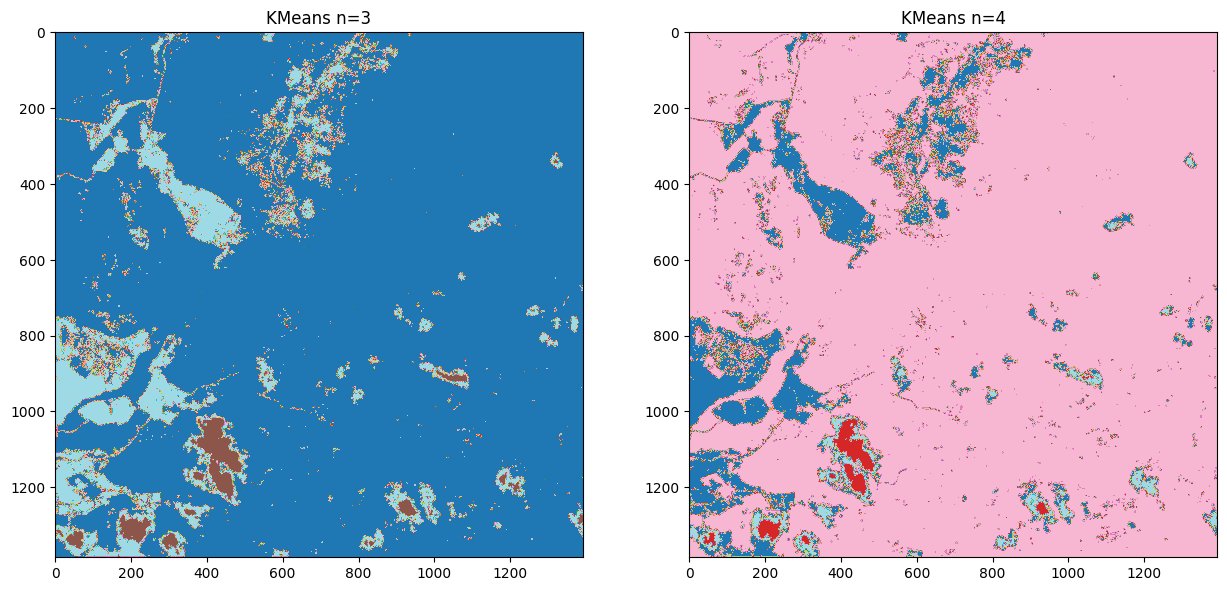

In [11]:
fig,((ax1,ax2)) = plt.subplots(1,2,figsize=(15, 15))

ax1.set_title(f'KMeans n=3')
ax1.imshow(X_cluster3, cmap="tab20")

ax2.set_title(f'KMeans n=4')
ax2.imshow(X_cluster4, cmap="tab20")
plt.show()

## Análise da 12 bandas do Sentinel 2

In [12]:

# Tell GDAL to throw Python exceptions, and register all drivers
gdal.UseExceptions()
gdal.AllRegister()

# Read in raster image
bands = np.zeros((img_ds.RasterYSize, img_ds.RasterXSize, len(os.listdir(os.path.join(pp,'S2_cutted')))),
               gdal_array.GDALTypeCodeToNumericTypeCode(img_ds.GetRasterBand(1).DataType))

# Resample bands with smaller shapes (B01= 232,231) (B02= 1393,1385)...
# Done in Preparo no FME

for i, b in enumerate(os.listdir(os.path.join(pp,'S2_cutted'))):
  aux_img_ds = gdal.Open(os.path.join(pp,'S2_cutted',b), gdal.GA_ReadOnly)
  bands[:, :, i] = aux_img_ds.GetRasterBand(1).ReadAsArray()

"""
    pixel waveLen
B1	60 m	443 nm	Ultra Blue (Coastal and Aerosol)
B2	10 m	490 nm	Blue
B3	10 m	560 nm	Green
B4	10 m	665 nm	Red
B5	20 m	705 nm	Visible and Near Infrared (VNIR)
B6	20 m	740 nm	Visible and Near Infrared (VNIR)
B7	20 m	783 nm	Visible and Near Infrared (VNIR)
B8	10 m	842 nm	Visible and Near Infrared (VNIR)
B8a	20 m	865 nm	Visible and Near Infrared (VNIR)
B9	60 m	940 nm	Short Wave Infrared (SWIR)
B10	60 m	1375 nm	Short Wave Infrared (SWIR) ~~~~~~~~ Ñ tem
B11	20 m	1610 nm	Short Wave Infrared (SWIR)
B12	20 m	2190 nm	Short Wave Infrared (SWIR)
          10000000 nm --> 1 cm até 10 m : Atmospheric window for radio wavelengths --> LF,HF,VHF,Radar P,UHF, Radar X
"""
new_shape = (bands.shape[0] * bands.shape[1], bands.shape[2]) # vetorizar cada banda da imagem
print (bands.shape)
print (new_shape)

X = bands[:, :, :13].reshape(new_shape)

print (X.shape)

(1385, 1393, 12)
(1929305, 12)
(1929305, 12)


Now fit it

Changing the classification is straight forward. In this example choose MiniBatchKMeans

In [13]:
MB_KMeans = cluster.MiniBatchKMeans(n_clusters=3)
MB_KMeans.fit(X)

X_cluster = MB_KMeans.labels_

X_cluster = X_cluster.reshape(bands[:, :, 0].shape)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


And plot

/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:394: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.
  return func(*args, **kwargs)


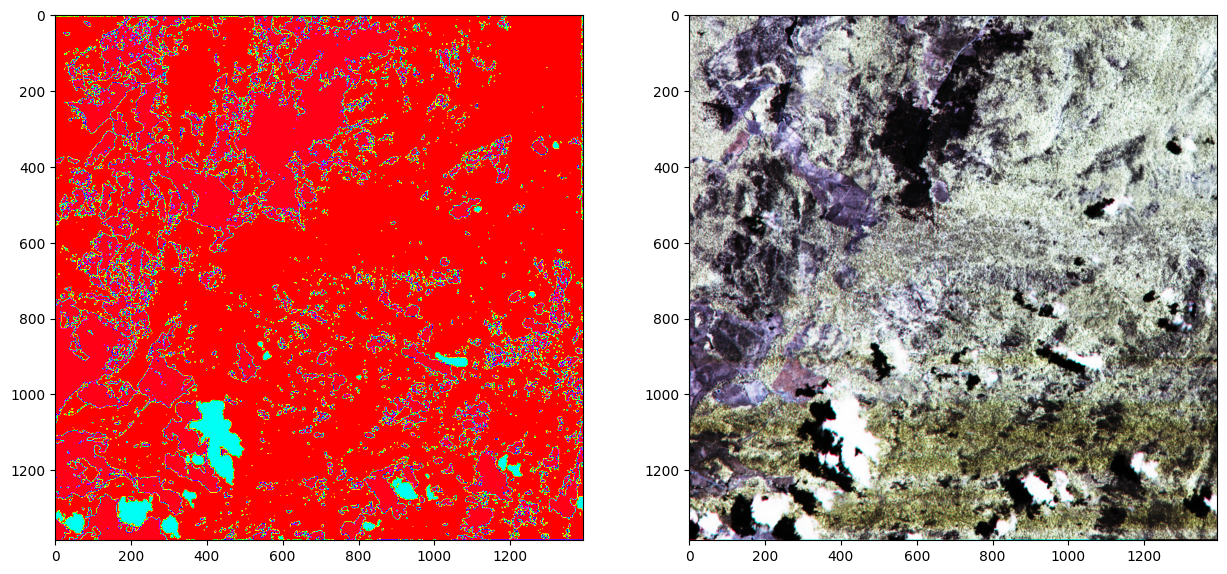

In [14]:
from sklearn.preprocessing import normalize
from skimage.exposure import equalize_hist

color = [ bands[:, :, 4], bands[:, :, 3], bands[:, :, 2]]
color = [ normalize(i , axis=1, norm='l2') for i in color]
color = np.array(color) # this is (3, 1385, 1393)
color = np.swapaxes(color, 2, 0) # this is (1393, 1385, 3)
color = np.swapaxes(color, 1, 0) # this is (1385, 1393, 3)
#color = equalize_hist(color)

fig,((ax1,ax2)) = plt.subplots(1,2,figsize=(15 , 15))
ax1.imshow(X_cluster, cmap="hsv") # this need to be (1385, 1393, 3) (M, N, 3): an image with RGB values (0-1 float or 0-255 int)
ax2.imshow(equalize_hist(color))

plt.show()

## Check the histogram of the newly classified image

{0: 1414034, 1: 33818, 2: 481453}


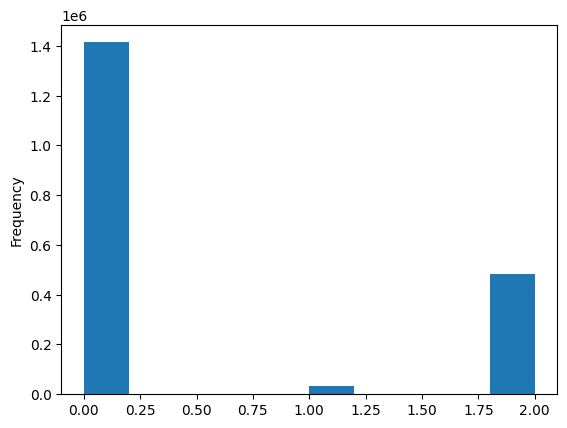

In [15]:
unique, counts = np.unique(X_cluster.reshape((-1,)), return_counts=True)
print(dict(zip(unique, counts)))

df= pd.Series(X_cluster.reshape((-1,)))
ax = df.plot.hist()

##Find what label is clouds

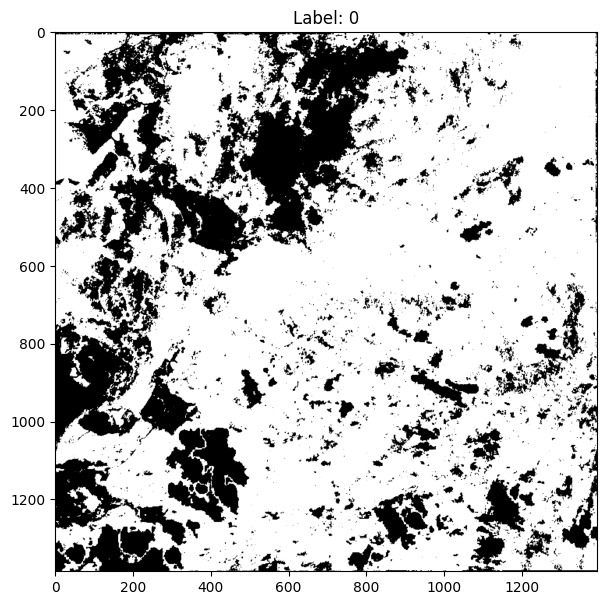

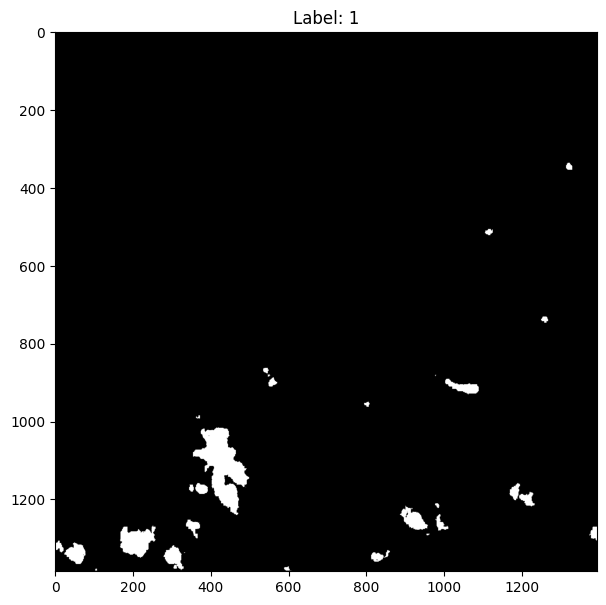

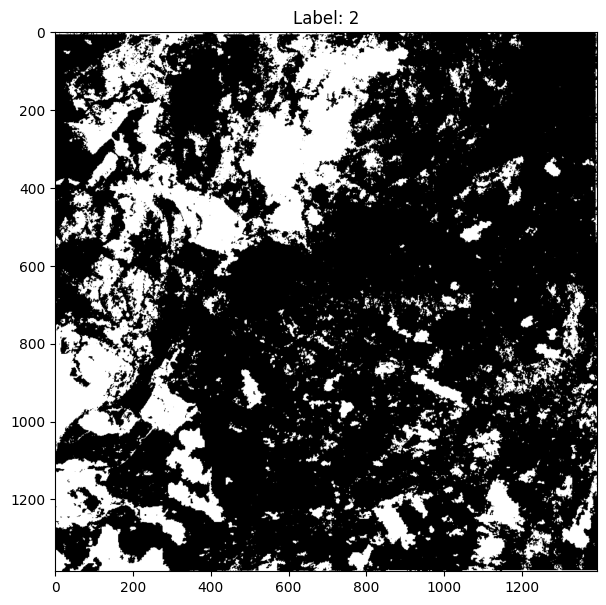

In [16]:
current_labels = unique #[0, 1, 2]
for i in range(len(current_labels)):
  desired_labels = np.zeros((3,))
  desired_labels[i] = 1
  map_dict = dict(zip(current_labels, desired_labels))
  X_cluster_class_by_class = np.array([map_dict[i] for i in X_cluster.reshape((-1,))])
  X_cluster_class_by_class = X_cluster_class_by_class.reshape(img.shape)
  plt.figure(figsize=(7,7))
  plt.title(f'Label: {current_labels[i]}')
  plt.imshow(X_cluster_class_by_class, cmap=plt.get_cmap("gray"))
  plt.show()

## Check final result

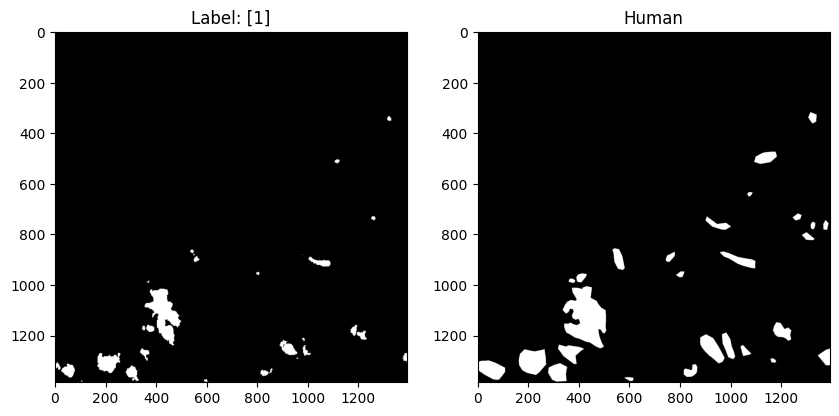

In [17]:
# Put choosen label into a var KmeansClouds
nuvens_label = 1 # Get from above
i = np.where(current_labels == nuvens_label)
desired_labels = np.zeros((3,))
desired_labels[i] = 1

map_dict = dict(zip(current_labels, desired_labels))
KmeansClouds = np.array([map_dict[i] for i in X_cluster.reshape((-1,))])
KmeansClouds = KmeansClouds.reshape(img.shape)

# Put Y by Kmeans an Y by operator side by side
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,10))
ax1.set_title(f'Label: {current_labels[i]}')
ax1.imshow(KmeansClouds, cmap=plt.get_cmap("gray"))
ax2.set_title(f'Human')
ax2.imshow(nuvens, cmap=plt.get_cmap("gray"))
plt.show()

## Save

In [18]:
## write out to tiff
### single band raster.

[cols, rows] = img.shape # from the 3rd cell

format = "GTiff"
driver = gdal.GetDriverByName(format)

outDataRaster = driver.Create(os.path.join(pp,"k_means.gtif"), rows, cols, 1, gdal.GDT_Byte)
outDataRaster.SetGeoTransform(img_ds.GetGeoTransform()) ##sets same geotransform as input
outDataRaster.SetProjection(img_ds.GetProjection()) ##sets same projection as input

outDataRaster.GetRasterBand(1).WriteArray(KmeansClouds)

outDataRaster.FlushCache() ## remove from memory
del outDataRaster ## delete the data (not the actual geotiff)

In [19]:
os.listdir(pp)

['S2',
 'S2_cutted',
 'Prints',
 'S2_AOI_nuvens',
 'Classification_CNN_S2.ipynb',
 'S2_area6_cutted',
 'S2_area8_cutted',
 'S2_area9_cutted',
 'Classification_MLP_S2.ipynb',
 'Classification_MLP_CBERS4A.ipynb',
 'CBERS4A',
 'k_means.gtif',
 'Classification_MLP_S2_P2.ipynb',
 'Clustering_KMeans-S2.ipynb']

## Métricas

In [20]:
from sklearn.metrics import accuracy_score, precision_score, f1_score
acc = accuracy_score(Y,KmeansClouds.reshape(-1,1))
pre = precision_score(Y,KmeansClouds.reshape(-1,1))
f1  = f1_score(Y,KmeansClouds.reshape(-1,1))
print(" accuracy_score:",acc,"\n","prec_score:",pre,"\n","f1_score:",f1)

 accuracy_score: 0.9743078466079754 
 prec_score: 0.9940268496067183 
 f1_score: 0.5756164383561643


## RGB recortada pelas nuvens

In [21]:
from scipy import ndimage

KmeansClouds = KmeansClouds.astype(int)

KmeansClouds_dil = ndimage.binary_dilation(KmeansClouds, iterations=50).astype(KmeansClouds.dtype)

current_labels = [0, 1]
desired_labels = [1, 0]
m = dict(zip(current_labels, desired_labels))
KmeansCloudsInv = np.array([ m[pixel[0]] for pixel in KmeansClouds_dil.reshape(-1,1)])
KmeansCloudsInv = KmeansCloudsInv.reshape(KmeansClouds.shape)

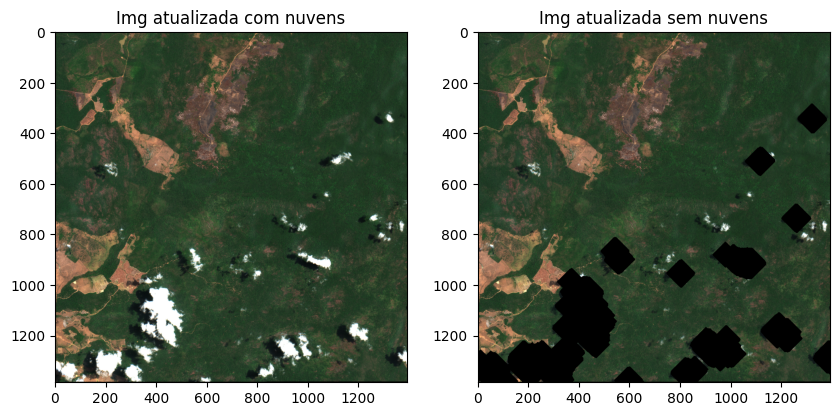

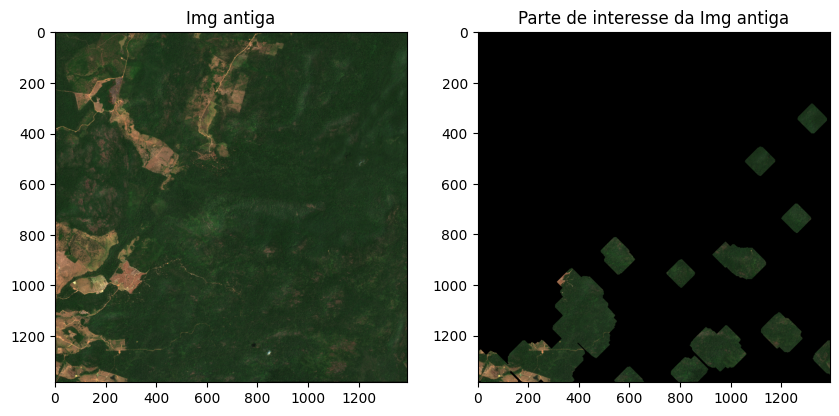

In [22]:
rgb_ds = os.path.join(pp,'S2_AOI_nuvens','S2B_tile_20190401_20NQH_0_TCI.tif')
rgb    = gdal.Open(rgb_ds, gdal.GA_ReadOnly).ReadAsArray()
color = [ rgb[0, :, :], rgb[1, :, :], rgb[2, :, :]]
color = np.array(color) # this is (3, 1385, 1393)
color = np.swapaxes(color, 2, 0) # this is (1393, 1385, 3)
color = np.swapaxes(color, 1, 0) # this is (1385, 1393, 3)

t1 = np.multiply(rgb[0, :, :] , KmeansCloudsInv)
t2 = np.multiply(rgb[1, :, :] , KmeansCloudsInv)
t3 = np.multiply(rgb[2, :, :] , KmeansCloudsInv)

rec_color = [ t1, t2, t3]
rec_color = np.array(rec_color) # this is (3, 1385, 1393)
rec_color = np.swapaxes(rec_color, 2, 0) # this is (1393, 1385, 3)
rec_color = np.swapaxes(rec_color, 1, 0) # this is (1385, 1393, 3)

f, (ax1,ax2) = plt.subplots(1,2,figsize=(10,10))
ax1.set_title("Img atualizada com nuvens")
ax1.imshow(color)
ax2.set_title("Img atualizada sem nuvens")
ax2.imshow(rec_color)
plt.show()

rgb_older_ds = os.path.join(pp,'S2_AOI_nuvens','S2A_tile_20190225_20NQH_0_TCI.tif')
rgb_old    = gdal.Open(rgb_older_ds, gdal.GA_ReadOnly).ReadAsArray()
color_old = [ rgb_old[0, :, :], rgb_old[1, :, :], rgb_old[2, :, :]]
color_old = np.array(color_old) # this is (3, 1385, 1393)
color_old = np.swapaxes(color_old, 2, 0) # this is (1393, 1385, 3)
color_old = np.swapaxes(color_old, 1, 0) # this is (1385, 1393, 3)

t1 = np.multiply(np.pad(rgb_old[0, :, :],((2,0),(0,1)),'constant',constant_values=(1, 1)) , KmeansClouds_dil)
t2 = np.multiply(np.pad(rgb_old[1, :, :],((2,0),(0,1)),'constant',constant_values=(1, 1)) , KmeansClouds_dil)
t3 = np.multiply(np.pad(rgb_old[2, :, :],((2,0),(0,1)),'constant',constant_values=(1, 1)) , KmeansClouds_dil)

rec_color_old = [ t1, t2, t3]
rec_color_old = np.array(rec_color_old) # this is (3, 1385, 1393)
rec_color_old = np.swapaxes(rec_color_old, 2, 0) # this is (1393, 1385, 3)
rec_color_old = np.swapaxes(rec_color_old, 1, 0) # this is (1385, 1393, 3)

f, (ax1,ax2) = plt.subplots(1,2,figsize=(10,10))
ax1.set_title("Img antiga")
ax1.imshow(color_old)
ax2.set_title("Parte de interesse da Img antiga")
ax2.imshow(rec_color_old)

plt.show()


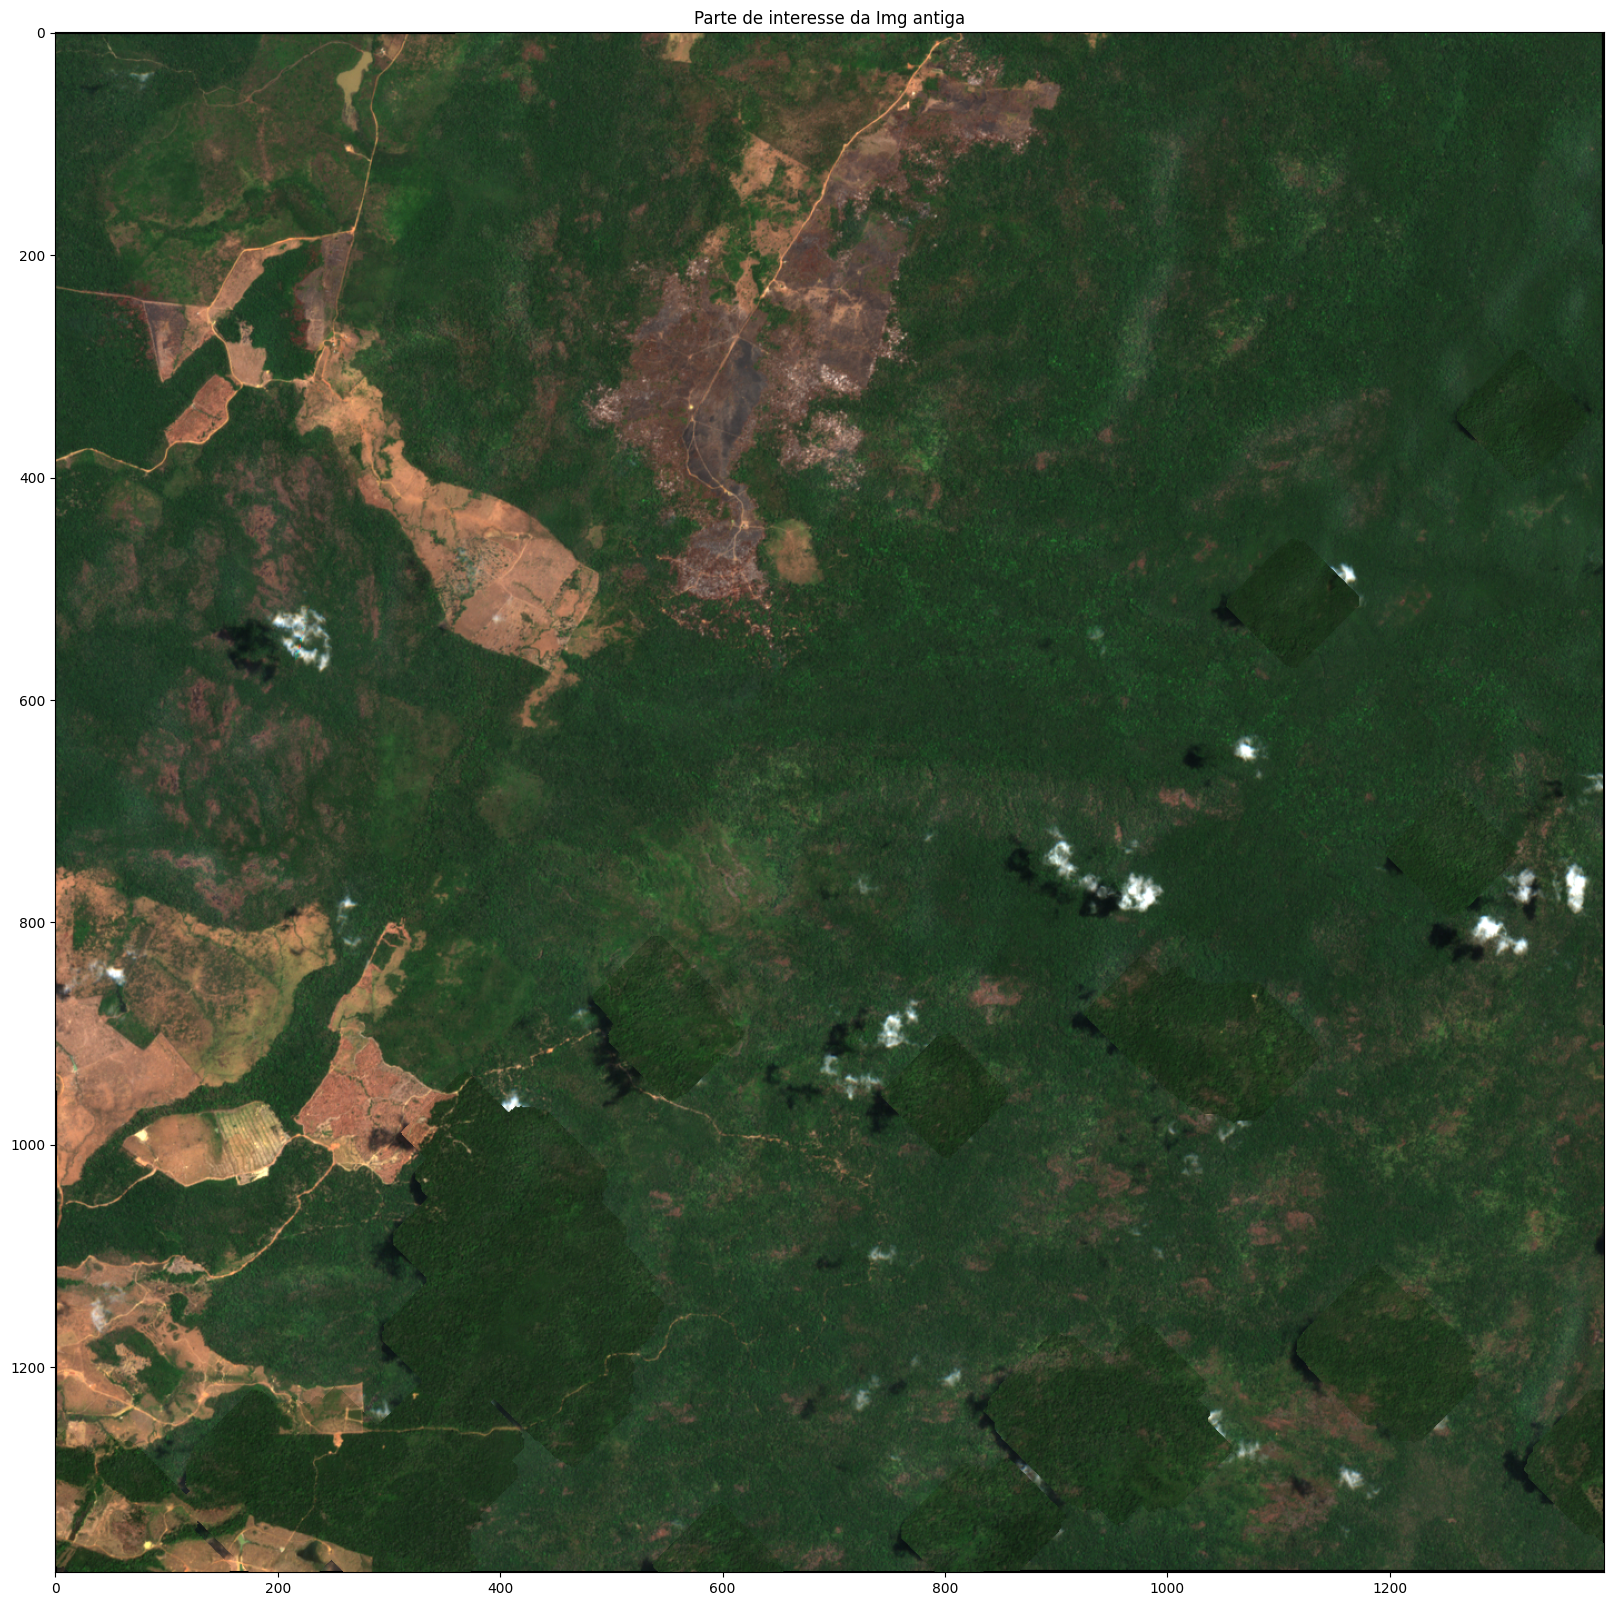

In [23]:
final = np.add(rec_color,rec_color_old)

f, (ax1) = plt.subplots(1,1,figsize=(20,20))

ax1.set_title("Parte de interesse da Img antiga")
ax1.imshow(final)

plt.show()

## Lições aprendidas

1. K Médias pode ser usado com efetividade e muita eficiência em imagens que conhecidamente possuem nuvens
2. Como não foram classificadas também as sombras a área de recorte pode ser dilatada para alcançar as respectivar sombras